In [7]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from numpy.random import permutation


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

ModuleNotFoundError: No module named 'weightedSHAP'

In [5]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
chdir('..') 
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/publication_notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/nancelab


In [6]:
#age_feature_path = workbookDir + '/data/raw_data_age/'
region_feature_path = '/Users/nelsschimek/Documents/nancelab/Data/OGD_severity/'
region_feature_filelist = [f for f in listdir(region_feature_path) if isfile(join(region_feature_path, f)) and 'feat' in f and 'cortex' in f]
print(len(region_feature_filelist))

40


In [24]:
fstats_tot_age = data_process.generate_fullstats(region_feature_path, region_feature_filelist, ['NT','1_5', '0_5'], 'OGD')

Adding file features_OGD_1_5h_slice_1_cortex_vid_3.csv size: (1736, 70)
Adding file features_OGD_1_5h_slice_1_cortex_vid_2.csv size: (1765, 70)
Adding file feat_NT_slice_2_cortex_vid_4.csv size: (1429, 67)
Adding file feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
Adding file features_OGD_1_5h_slice_1_cortex_vid_1.csv size: (2565, 70)
Adding file feat_NT_slice_2_cortex_vid_5.csv size: (2210, 67)
Adding file feat_NT_slice_2_cortex_vid_1.csv size: (1388, 67)
Adding file features_OGD_1_5h_slice_1_cortex_vid_5.csv size: (1635, 70)
Adding file features_OGD_1_5h_slice_1_cortex_vid_4.csv size: (1190, 70)
Adding file feat_NT_slice_2_cortex_vid_2.csv size: (1784, 67)
Adding file feat_NT_slice_1_cortex_vid_8.csv size: (1984, 67)
Adding file feat_NT_slice_1_cortex_vid_9.csv size: (6506, 67)
Adding file feat_NT_slice_2_cortex_vid_3.csv size: (3520, 67)
Adding file features_OGD_0_5h_slice_1_cortex_vid_1.csv size: (1783, 70)
Adding file features_OGD_0_5h_slice_1_cortex_vid_3.csv size: (2479, 70)

In [20]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'OGD'

In [25]:
ecm = fstats_tot_age[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
#ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm = ecm[~ecm[list(set(feature_list))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

ecm.shape

(144669, 37)


(17348, 37)

In [132]:
ecm = ecm.drop_duplicates(subset=['Mean Deff1', 'Mean Deff2'], keep='first') # Remove duplicate track_IDs
ecm.shape

(5158, 37)

In [112]:
for feat in feature_list:
    #ecm[feat] = scale(ecm[feat].values)
    print(ecm[feat].mean())

0.8477202871476953
2.3720012172867775
4.402172159448458
0.6783334508825524
0.29759863937193815
0.24802589374774336
20672454877464.703
0.43640089113436054
0.03210045974049213
2.8658423633852657
-0.21744790394564797
0.16683439810342587
0.023615671867981226
0.6779161384099233
415.7409414556962
0.4579347758603855
0.26800878793887617
0.7941705569374307
2.175448580757581
4.285356867295089
0.7185056373555081
0.2656711200347871
0.282406875147561
18447073804335.21
0.49095289574939804
0.07357666429456775
2.423680153308587
-0.20494826255618134
0.3279497401981865
0.0976348568239359
1.4603393366270407
0.7667497775872475
0.26409045409816656


In [133]:
ecm_filt = ecm[ecm['Mean Deff1'] < 50]
ecm_filt.shape

(5158, 37)

In [8]:
def full_preprocess(ecm, balanced=True, y_scramble=False, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        bal_ecm = bal_ecm.reset_index(drop=True)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    if y_scramble:
        perm = permutation(len(label_df))
        label_shuffled = label_df[perm]
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(label_shuffled)
    else:
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.7
    test_split = 0.5


    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [29]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [26]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
label_df = bal_ecm[target]
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.8
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

Ratio before data balance (1_5:NT:0_5) = 4469:6575:6304
Ratio after balance (1_5:NT:0_5) = 4469:4469:4469


In [11]:
best_param = predxgboost.xgb_paramsearch(X_train, y_train, feature_list, init_params=param, num_round=1000, nfold=5, early_stopping_rounds=10, verbose_eval=10)

Using CV with subsample={0.6}, colsample_bytree={0.9}
New best param found: mlogloss = {0.6571953144551803}, boost_rounds = {1999}
Using CV with subsample={0.6}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={1.0}
Using CV with subsample={1.0}, colsample_bytree={0.9}
Using CV with subsample={1.0}, colsample_bytree={0.5}
Using CV with subsample={0.6}, colsample_bytree={1.0}
New best param found: mlogloss = {0.6566691195828949}, boost_rounds = {1999}
Using CV with max_depth={2}, min_child_weight={10}
Using CV with max_depth={2}, min_child_weight={0}
Using CV with max_depth={3}, min_child_weight={10}
New best param found: mlogloss = {0.6564722424184445}, boost_rounds = {1999}
Using CV with max_depth={3}, min_child_weight={0}
Using CV with max_depth={10}, min_child_weight={10}
New best param found: mlogloss = {0.6537373381804268}, boost_rounds = {1715}
Using CV with max_depth={5}, min_child_weight={10}
New best param found: mlogloss = {0.6477004983258395}, boost_ro

In [12]:
print(best_param)

(      train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0                1.092679            0.000054            1.093619   
1                1.086795            0.000074            1.088677   
2                1.080989            0.000082            1.083799   
3                1.075288            0.000179            1.078938   
4                1.069748            0.000295            1.074342   
...                   ...                 ...                 ...   
1038             0.323010            0.011082            0.642843   
1039             0.322831            0.011081            0.642820   
1040             0.322705            0.011061            0.642791   
1041             0.322538            0.011070            0.642754   
1042             0.322424            0.011076            0.642751   

      test-mlogloss-std  
0              0.000283  
1              0.000601  
2              0.000967  
3              0.001060  
4              0.001367  
...           

In [27]:
best_param_cort = {'max_depth': 5, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eval_metric': 'mlogloss'}

In [10]:
#best_param = {'max_depth': 4, 'eta': 0.005, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 5.0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eval_metric': 'mlogloss'}

In [30]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=1042, verbose=True)


[0]	train-mlogloss:1.09636	eval-mlogloss:1.09646
[1]	train-mlogloss:1.09426	eval-mlogloss:1.09445
[2]	train-mlogloss:1.09212	eval-mlogloss:1.09245
[3]	train-mlogloss:1.08992	eval-mlogloss:1.09035
[4]	train-mlogloss:1.08767	eval-mlogloss:1.08813
[5]	train-mlogloss:1.08548	eval-mlogloss:1.08594
[6]	train-mlogloss:1.08329	eval-mlogloss:1.08383
[7]	train-mlogloss:1.08112	eval-mlogloss:1.08164
[8]	train-mlogloss:1.07888	eval-mlogloss:1.07943
[9]	train-mlogloss:1.07679	eval-mlogloss:1.07735
[10]	train-mlogloss:1.07482	eval-mlogloss:1.07554
[11]	train-mlogloss:1.07278	eval-mlogloss:1.07367
[12]	train-mlogloss:1.07065	eval-mlogloss:1.07159
[13]	train-mlogloss:1.06882	eval-mlogloss:1.06989
[14]	train-mlogloss:1.06669	eval-mlogloss:1.06780
[15]	train-mlogloss:1.06470	eval-mlogloss:1.06588
[16]	train-mlogloss:1.06278	eval-mlogloss:1.06404
[17]	train-mlogloss:1.06078	eval-mlogloss:1.06198
[18]	train-mlogloss:1.05875	eval-mlogloss:1.05994
[19]	train-mlogloss:1.05674	eval-mlogloss:1.05798
[20]	train

In [32]:
#class_names = le.classes_
class_names = ['0.5h', '1.5h', 'HC']
class_results = classification_report(true_label, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

        0.5h     0.6698    0.5399    0.5979       526
        1.5h     0.5650    0.6653    0.6111       490
          HC     0.8424    0.8698    0.8559       461

    accuracy                         0.6845      1477
   macro avg     0.6924    0.6917    0.6883      1477
weighted avg     0.6889    0.6845    0.6828      1477



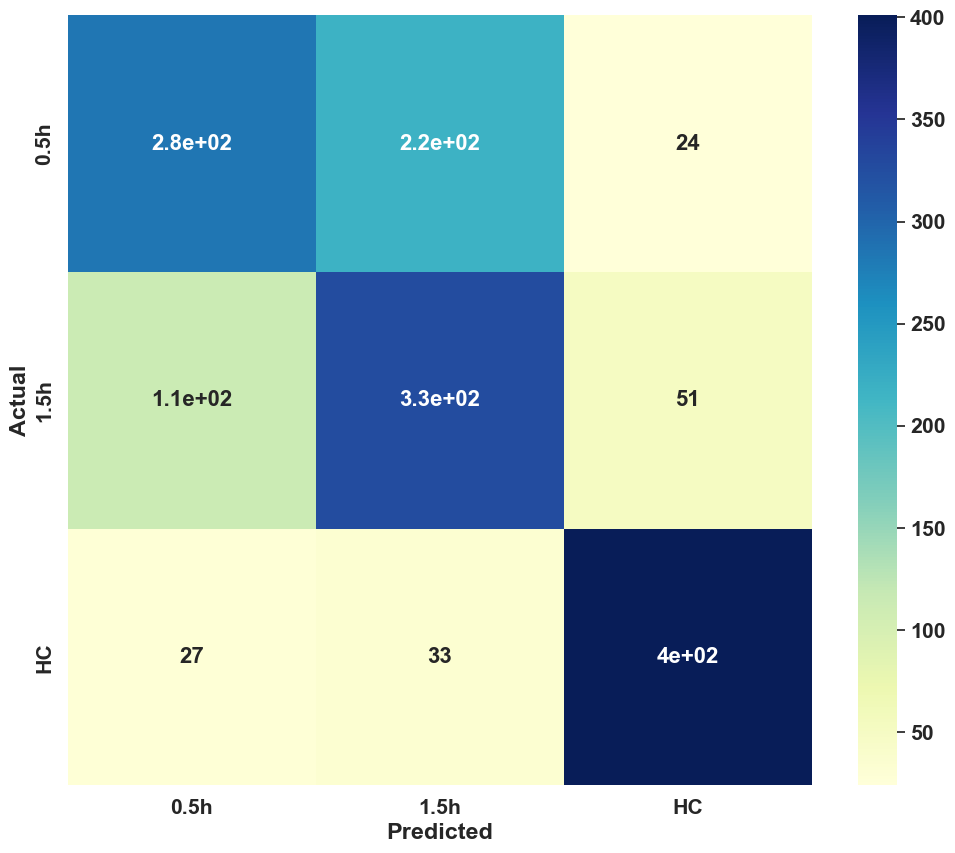

In [34]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [35]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

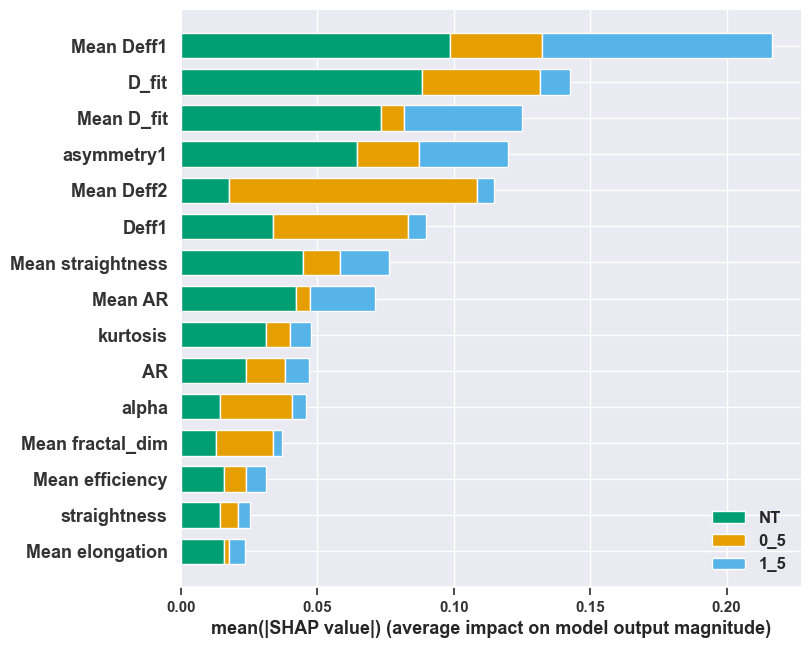

In [141]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [33]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [89]:
le.classes_

array(['0_5', '1_5', 'NT'], dtype=object)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Top 5 Features for 0.5h')

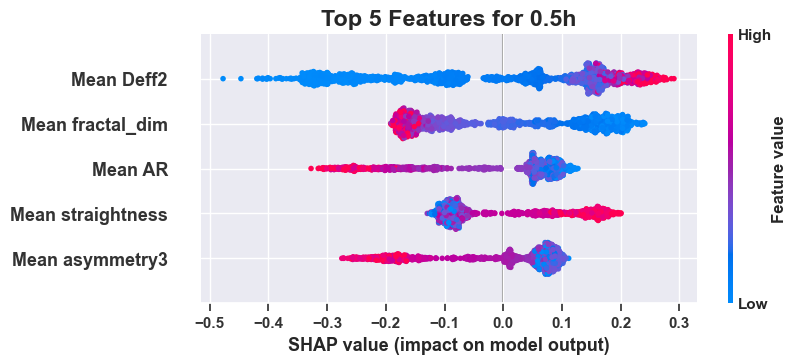

In [36]:
shap.summary_plot(shap_values[0], X_test[feature_list], max_display=5, show=False, color_bar=True)
plt.gcf().axes[-1].set_aspect(50)
plt.gcf().axes[-1].set_box_aspect(50)
plt.title(f'Top 5 Features for {class_names[0]}')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Top 5 Features for 1.5h')

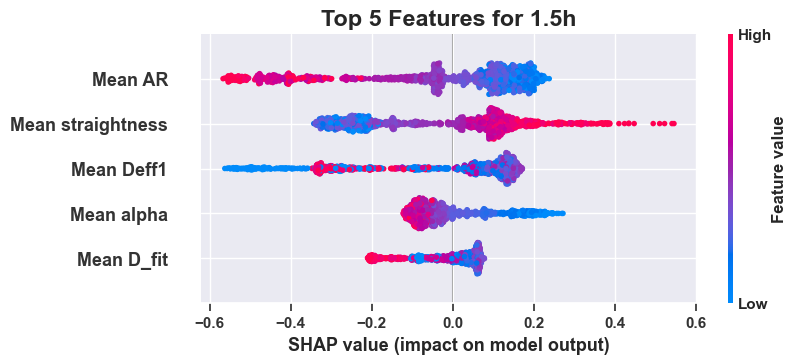

In [37]:
shap.summary_plot(shap_values[1], X_test[feature_list], max_display=5, show=False, color_bar=True)
plt.gcf().axes[-1].set_aspect(50)
plt.gcf().axes[-1].set_box_aspect(50)
plt.title(f'Top 5 Features for {class_names[1]}')
#plt.savefig('striatum_shap_new.pdf', dpi=300, bbox_inches='tight')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Top 5 Features for HC')

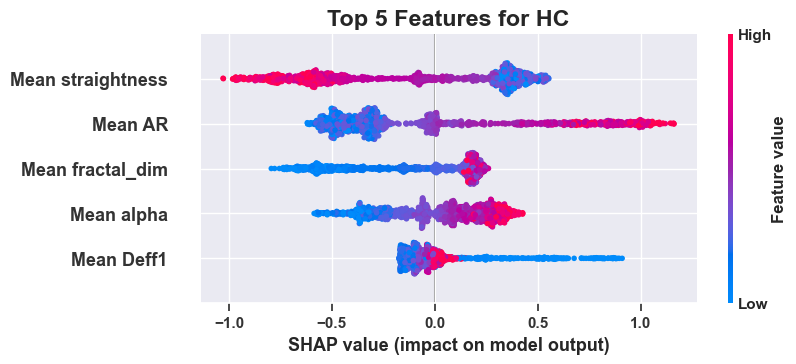

In [38]:
shap.summary_plot(shap_values[2], X_test[feature_list], max_display=5, show=False, color_bar=True)
plt.gcf().axes[-1].set_aspect(50)
plt.gcf().axes[-1].set_box_aspect(50)
plt.title(f'Top 5 Features for {class_names[2]}')

Plotting SHAP values for 1_5


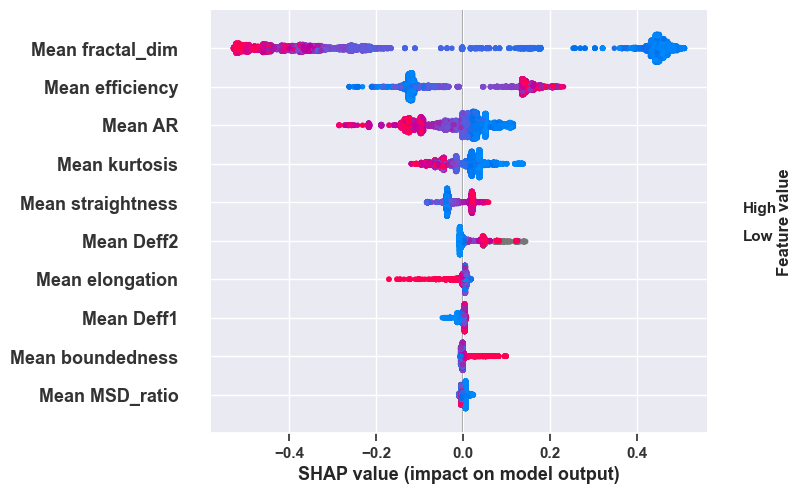

Plotting SHAP values for NT


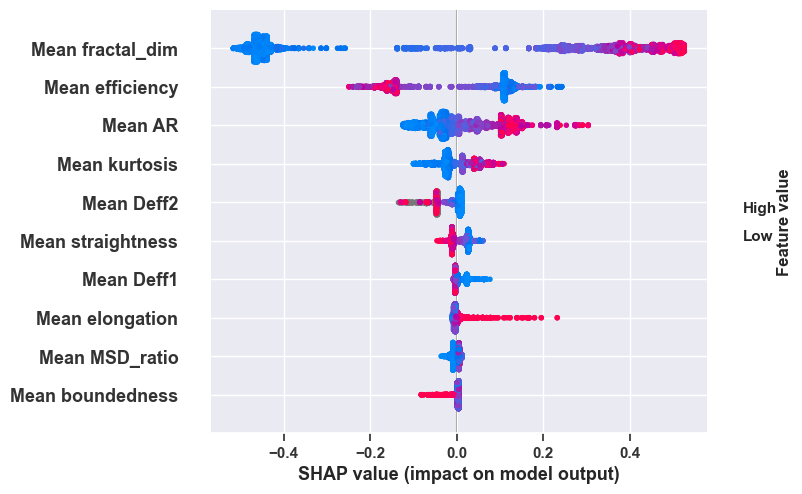

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 750x500 with 0 Axes>

In [59]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

for i in range(3): 
    figsize = (7.5, 5)
    fig = plt.figure(figsize=figsize)
    # ax = fig.gca()
    print(f'Plotting SHAP values for {le.classes_[i]}')
    shap.summary_plot(shap_values[i], X_test[feature_list], max_display=10, title=f'SHAP Values for {le.classes_[i]}', color=cmap)

In [110]:
explainer.

SyntaxError: invalid syntax (3702948619.py, line 1)

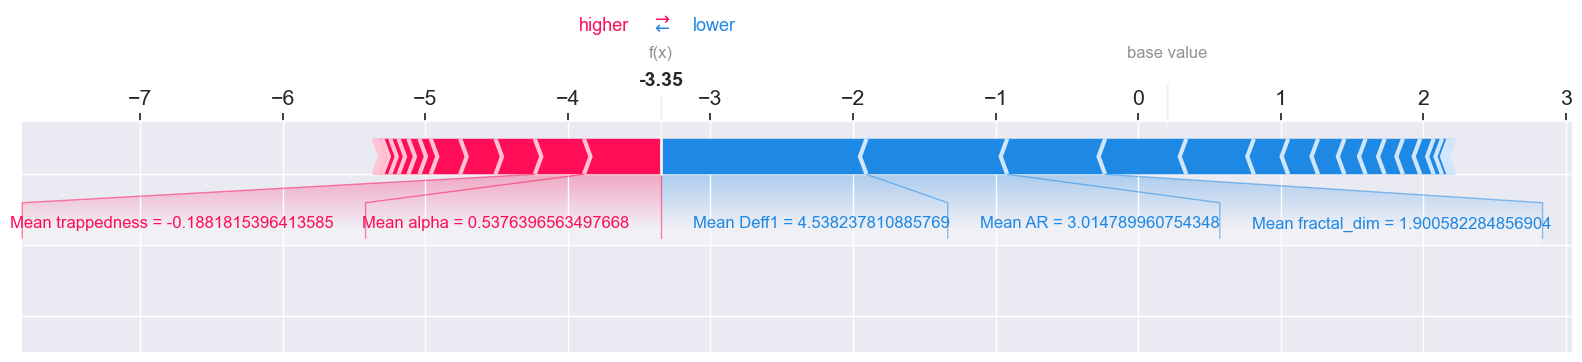

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[features].iloc[0,:], matplotlib=True)

In [ ]:
X_display

NameError: name 'X_display' is not defined

alpha
D_fit
kurtosis
asymmetry1
asymmetry2
asymmetry3
AR
elongation
boundedness
fractal_dim
trappedness
efficiency
straightness
MSD_ratio
Deff1
Deff2
Mean alpha


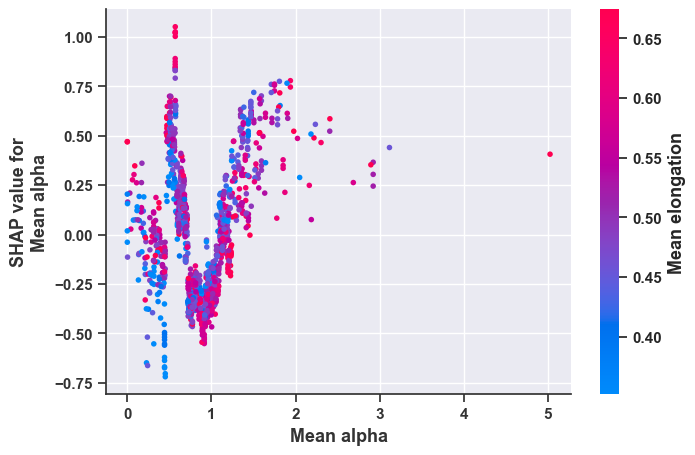

Mean D_fit


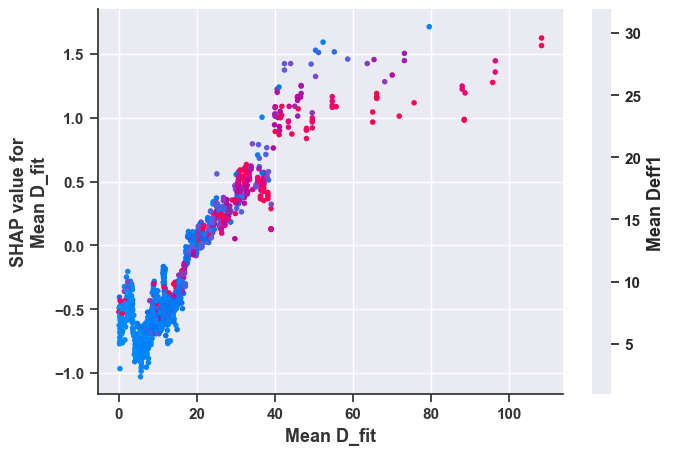

Mean kurtosis


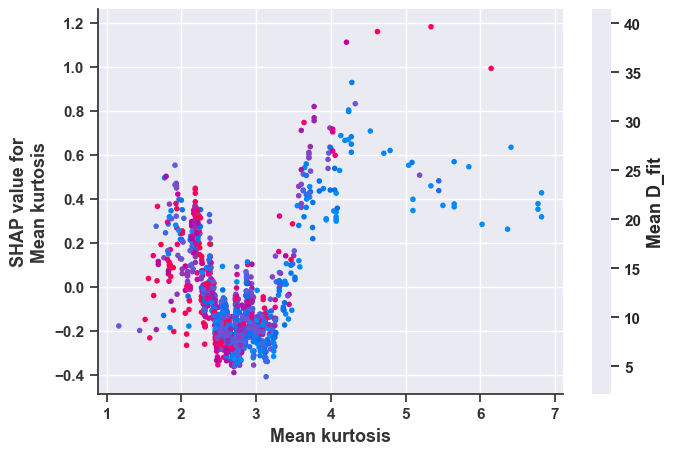

Mean asymmetry1


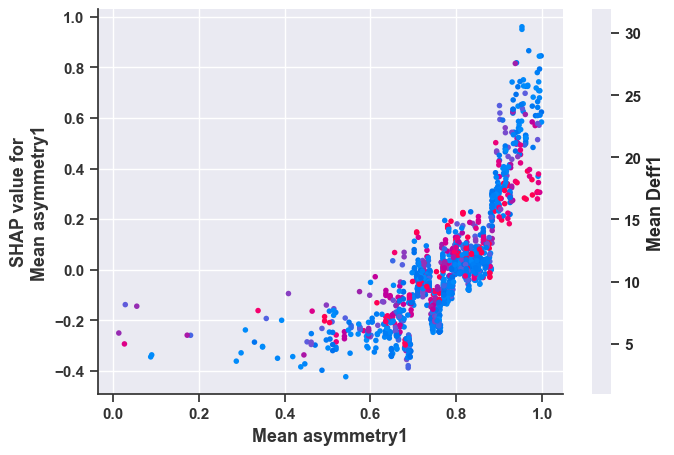

Mean asymmetry2


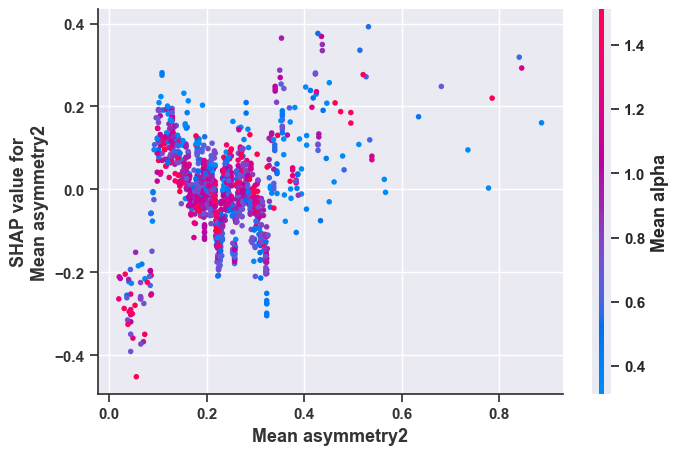

Mean asymmetry3


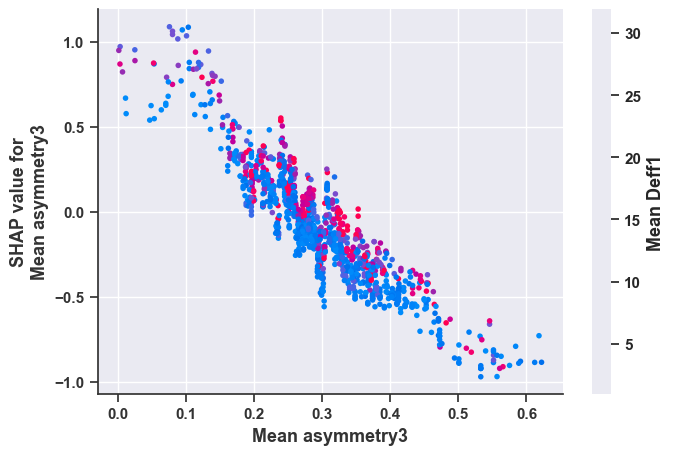

Mean AR


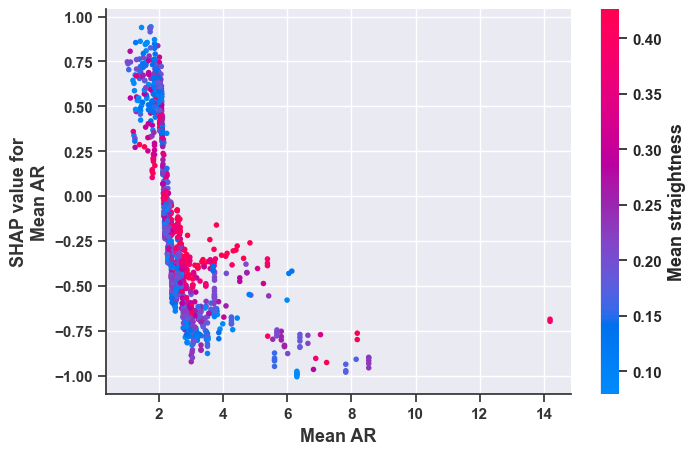

Mean elongation


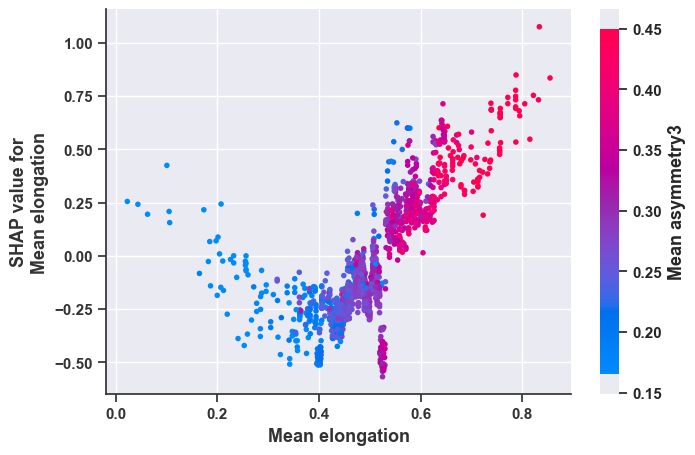

Mean boundedness


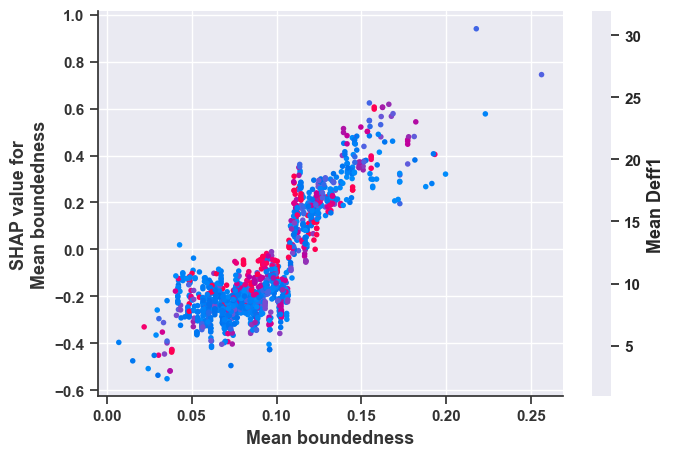

Mean fractal_dim


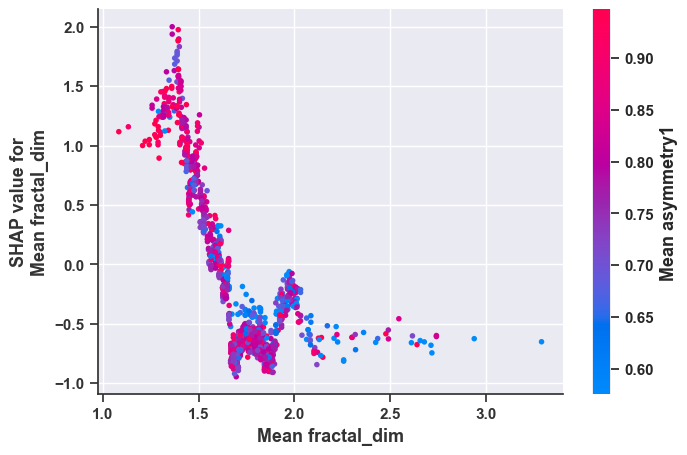

Mean trappedness


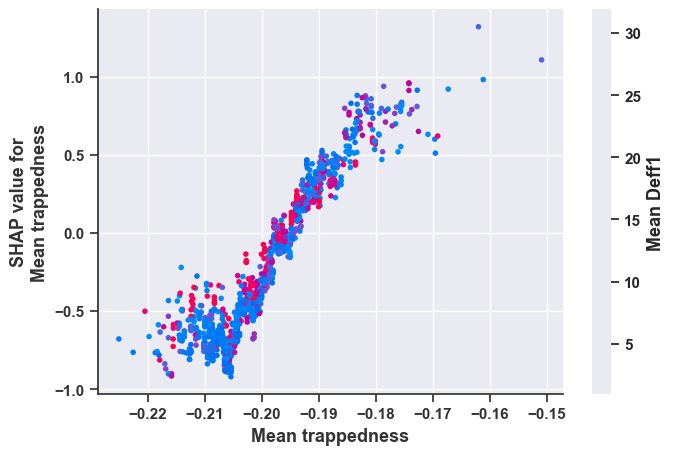

Mean efficiency


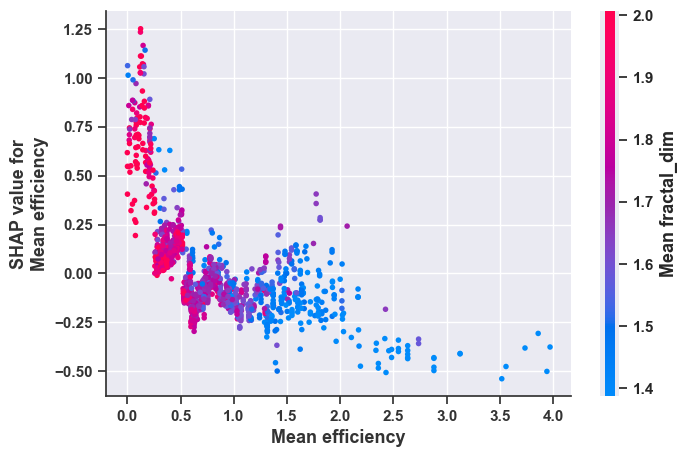

Mean straightness


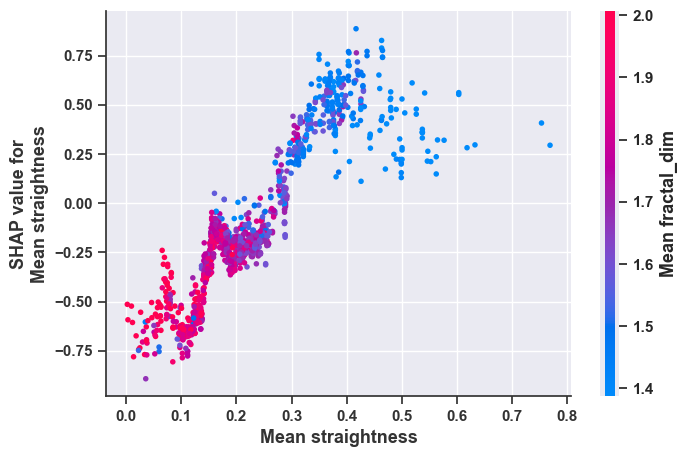

Mean MSD_ratio


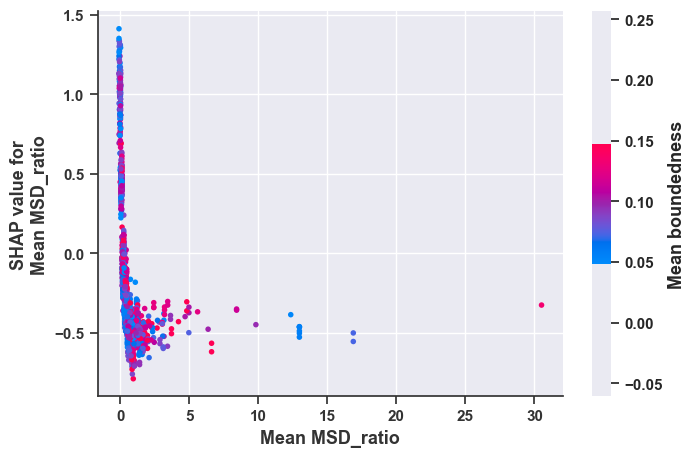

Mean Deff1


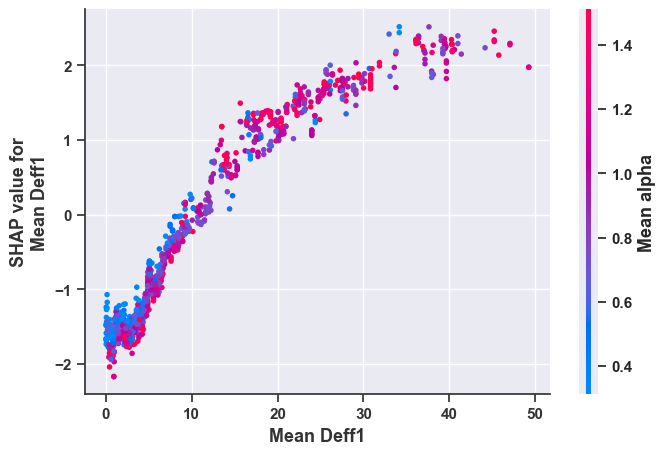

Mean Deff2


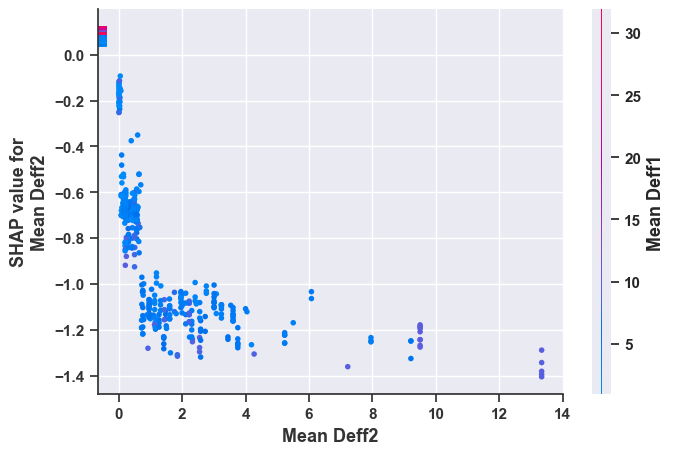

In [128]:
for name in X_train[features].columns:
    print(name)
    if 'Mean' in name:
        shap.dependence_plot(ind=name, shap_values=shap_values[0], features=X_test[features])

In [138]:
shap_interaction_values = explainer.shap_interaction_values(X_test[features])

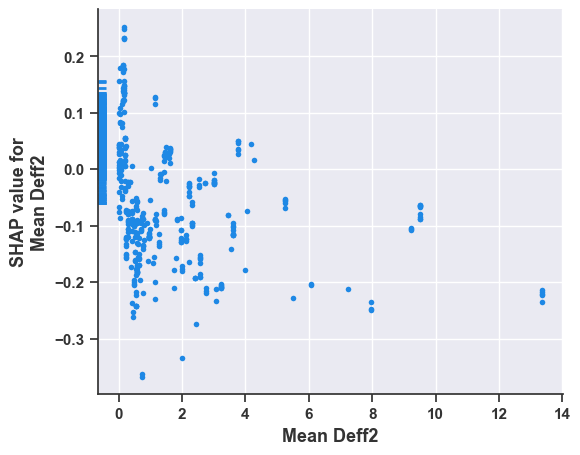

In [180]:
shap.dependence_plot(ind='Mean Deff2', shap_values=shap_values[2], features=X_test[features], interaction_index=None)

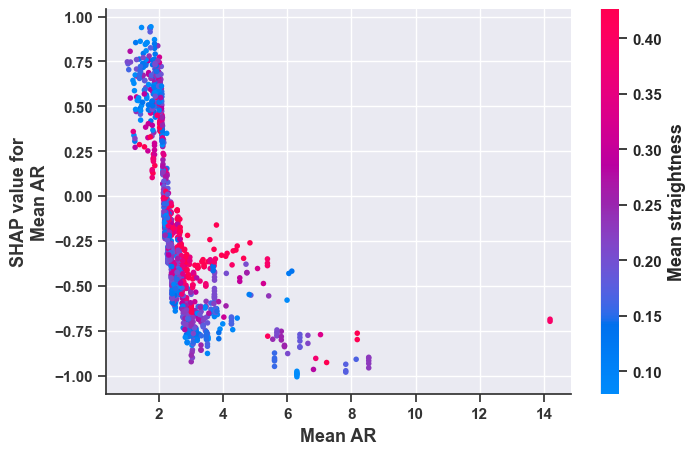

In [166]:
shap.dependence_plot(ind='Mean AR', shap_values=shap_values[0], features=X_test[features], interaction_index='auto')

In [167]:
shap_interaction_values[0].shape

(1340, 32, 32)

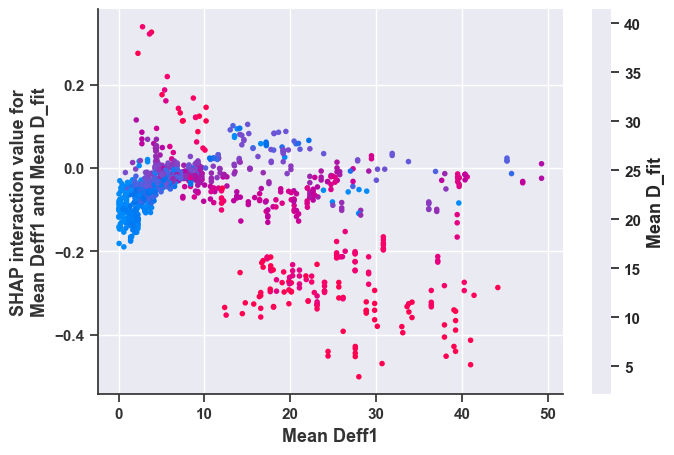

In [175]:
shap.dependence_plot(("Mean Deff1", "Mean D_fit"), shap_interaction_values[0], X_test[features])#, interaction_index="Mean elongation")

In [135]:
X_test[features].shape

(1340, 32)

In [137]:
shap_interaction_values[0].shape

(1430, 32, 32)